In [1]:
!python -m pip install traitlets==4.3.3 --force-reinstall
!pip install pywin32==228
!pip install tiktoken
#installing past numpy version
!pip install gensim
!pip install numpy==1.21.6

import torch
import tiktoken
import torch
import torch.nn as nn
import torch.nn.functional as F
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from gensim.models import KeyedVectors


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.__version__)



print(torch.cuda.is_available())



     |████████████████████████████████| 75 kB 2.4 MB/s eta 0:00:011
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: ipython-genutils
    Found existing installation: ipython-genutils 0.2.0
    Uninstalling ipython-genutils-0.2.0:
      Successfully uninstalled ipython-genutils-0.2.0
  Attempting uninstall: decorator
    Found existing installation: decorator 4.4.2
    Uninstalling decorator-4.4.2:
      Successfully uninstalled decorator-4.4.2
  Attempting uninstall: traitlets
    Found existing installation: traitlets 5.0.5
    Uninstalling traitlets-5.0.5:
      Successfully uninstalled traitlets-5.0.5
You should consider upgrading via the '/usr/local/python39/bin/python -m pip install --upgrade pip' command.
ERROR: Could not find a version that satisfies the requirement pywin32==228
ERROR: No matching distribution found for pywin32==228
You should consider upgrading

In [2]:
def get_batch(data, seq_len, i):
    """Get a batch of data
    Parameters
    ----------
    data : torch.tensor
        The data to get the batch from
    seq_len : int
        The length of the sequence
    i : int
        The batch index
    Returns
    -------
    torch.tensor
        The input sequence
    torch.tensor
        The target sequence
    """
    seq_len = min(seq_len, len(data) - 1 - i)
    inputs = data[i: i + seq_len]
    targets = data[i + 1: i + 1 + seq_len].reshape(-1)
    return inputs, targets

def get_random_batch(split_type='train', block_size=8, batch_size = 4):
    """Get a random batch of data
    Parameters
    ----------
    split_type : str, optional
        The split to get the batch from, by default 'train'
    block_size : int, optional
        The size of the block (quantity of words per example in the batch), by default 8
    batch_size : int, optional
        The batch size (quantity of examples in the batch), by default 4    
    Returns
    -------
    torch.tensor
        The input sequence of size (batch_size, block_size)
    torch.tensor
        The target sequence of size (batch_size, block_size)
    """
    data = train_data if split_type == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    
    x, y = x.to(device), y.to(device)
    
    return x, y



# TEXT IMPORT (can be changed later on)

In [1]:
#with open('./data/wiki_eng.txt', "r", encoding = 'utf-8') as f:
#    text = f.read()
#    
#print(text[:1000])

In [2]:
with open('./data/don_quixote.txt', "r", encoding = 'utf-8') as f:
    text = f.read()




text= text.replace('\n', ' ').replace('  ', ' ')[121506:]
#text= text.replace(', ', ' , ').replace(': ', ' : ').replace('. ', ' . ').replace('; ', ' ; ').replace('? ', ' ? ').replace('! ', ' ! ')
#text = re.sub(r'(\W|\d)', r' \1 ', text)
text = text.lower()
print(text[:1000])


volume i.  chapter i. which treats of the character and pursuits of the famous gentleman don quixote of la mancha  in a village of la mancha, the name of which i have no desire to call to mind, there lived not long since one of those gentlemen that keep a lance in the lance-rack, an old buckler, a lean hack, and a greyhound for coursing. an olla of rather more beef than mutton, a salad on most nights, scraps on saturdays, lentils on fridays, and a pigeon or so extra on sundays, made away with three-quarters of his income. the rest of it went in a doublet of fine cloth and velvet breeches and shoes to match for holidays, while on week-days he made a brave figure in his best homespun. he had in his house a housekeeper past forty, a niece under twenty, and a lad for the field and market-place, who used to saddle the hack as well as handle the bill-hook. the age of this gentleman of ours was bordering on fifty; he was of a hardy habit, spare, gaunt-featured, a very early riser and a great 

In [4]:
import re

def split_into_words_special_chars_and_spaces(text):
    return re.findall('\w+|\S|\s', text)

text_separated = split_into_words_special_chars_and_spaces(text)
print(text_separated[:100])

['volume', ' ', 'i', '.', ' ', ' ', 'chapter', ' ', 'i', '.', ' ', 'which', ' ', 'treats', ' ', 'of', ' ', 'the', ' ', 'character', ' ', 'and', ' ', 'pursuits', ' ', 'of', ' ', 'the', ' ', 'famous', ' ', 'gentleman', ' ', 'don', ' ', 'quixote', ' ', 'of', ' ', 'la', ' ', 'mancha', ' ', ' ', 'in', ' ', 'a', ' ', 'village', ' ', 'of', ' ', 'la', ' ', 'mancha', ',', ' ', 'the', ' ', 'name', ' ', 'of', ' ', 'which', ' ', 'i', ' ', 'have', ' ', 'no', ' ', 'desire', ' ', 'to', ' ', 'call', ' ', 'to', ' ', 'mind', ',', ' ', 'there', ' ', 'lived', ' ', 'not', ' ', 'long', ' ', 'since', ' ', 'one', ' ', 'of', ' ', 'those', ' ', 'gentlemen', ' ']


In [5]:
vocabulary = list(set(text_separated))
print(vocabulary[0:100])
print("VOC LENGTH: ", len(vocabulary))

['footing', 'sternness', 'tanneries', 'fifer', 'fulfilment', 'instil', 'occurring', 'grunted', 'sublime', 'dessert', 'cleverness', 'turpin', 'feeling', 'attentions', 'killed', 'incident', 'exclaimed', 'zealous', 'entreats', 'surging', 'farthingales', 'yourself', 'brooding', 'skirts', 'li', 'tracks', 'creed', 'uproar', 'plebeians', 'frisking', 'slays', 'opposite', 's', 'chewed', 'showy', 'sancho', 'embassy', 'obey', 'eternity', 'pernicious', 'win', 'chickens', 'mas', 'decide', 'arbitrators', 'waters', 'juma', 'fishes', 'pedigrees', 'discovered', 'hills', 'thigh', 'brows', 'guillermo', 'bewails', 'speedy', 'prizes', 'proclamations', 'prospects', 'soar', 'headforemost', 'ciceronian', 'scarcely', 'frightful', 'polo', 'braver', 'sympathise', 'nicolao', 'spurning', 'higher', 'tourney', 'furry', 'quality', 'tailor', 'folds', 'intact', 'annals', 'sweep', 'protesting', 'cavaliers', 'rarest', 'wooed', 'dignities', 'laced', 'rumia', 'bellowing', 'cupbearer', 'treason', 'shopkeeper', 'entertaining

In [6]:
set(text_separated[:10])

{' ', '.', 'chapter', 'i', 'volume'}

In [7]:
print('Chracters on .txt file: ', len(text))
print('Words on .txt file: ', len(text.split(' ')))


chars = sorted(list(set(text)))
char_vocab_size = len(chars)

words_vocab_size = len(vocabulary)

print('Unique characters: ', char_vocab_size)
print('Unique words: ', words_vocab_size)


Chracters on .txt file:  2180846
Words on .txt file:  408335
Unique characters:  54
Unique words:  14836


# TRAINING DATA PREPARATION

## NORMAL TOKENIZATION

In [8]:
# For now, we will be using a basic encoding using only individual characters

stoi = { ch:i for i,ch in enumerate(vocabulary) }
itos = { i:ch for i,ch in enumerate(vocabulary) }

def encode(text_string):
    sep_text =split_into_words_special_chars_and_spaces(text_string)
    return [stoi[i] for i in sep_text]

def decode(encoded_text_list):
    decoded_text = [itos[i] for i in encoded_text_list]
    return ''.join(decoded_text)
    

print(encode(text[100:200]))
print(decode(encode(text[100:200])))



[7053, 4762, 7053, 10028, 7053, 4320, 7053, 7053, 2375, 7053, 10290, 7053, 2910, 7053, 4762, 7053, 10028, 7053, 4320, 7237, 7053, 5443, 7053, 4473, 7053, 4762, 7053, 5412, 7053, 12809, 7053, 10337, 7053, 9123, 7053, 12663, 7053, 5954, 7053, 4400, 7053, 5954, 7053, 3357, 7237, 7053, 9933, 7053]
 of la mancha  in a village of la mancha, the name of which i have no desire to call to mind, there 


## (NOT WORKING YET) TOKENIZATION: Using TikToken For Tokenization (can be changed later on to other like SentencePiece)
Tiktoken does tokenization per word and special character.

In [9]:
enc = tiktoken.get_encoding('gpt2')

tokenized_text = enc.encode(text)
print(len(tokenized_text))

print(len(text.split(' ')))

token_voc_size = len(list(set(tokenized_text)))
print('UNIQUE TOKENS: ',token_voc_size )

517242
408335
UNIQUE TOKENS:  12465


In [10]:
data = torch.tensor(tokenized_text, dtype=torch.long)

print('Encoded text: ', tokenized_text[:100])
print('Decoded text: ', enc.decode(tokenized_text[:100])) 

Encoded text:  [29048, 1312, 13, 220, 6843, 1312, 13, 543, 18432, 286, 262, 2095, 290, 45968, 286, 262, 5863, 22427, 836, 627, 844, 1258, 286, 8591, 582, 11693, 220, 287, 257, 7404, 286, 8591, 582, 11693, 11, 262, 1438, 286, 543, 1312, 423, 645, 6227, 284, 869, 284, 2000, 11, 612, 5615, 407, 890, 1201, 530, 286, 883, 28527, 326, 1394, 257, 300, 590, 287, 262, 300, 590, 12, 39638, 11, 281, 1468, 10230, 1754, 11, 257, 10904, 8156, 11, 290, 257, 13791, 39047, 329, 1093, 12215, 13, 281, 267, 8466, 286, 2138, 517, 12023, 621, 4517, 1122, 11, 257, 20698, 319]
Decoded text:  volume i.  chapter i. which treats of the character and pursuits of the famous gentleman don quixote of la mancha  in a village of la mancha, the name of which i have no desire to call to mind, there lived not long since one of those gentlemen that keep a lance in the lance-rack, an old buckler, a lean hack, and a greyhound for coursing. an olla of rather more beef than mutton, a salad on


## (NOT WORKING YET) EMBEDDING: Implementing Word2Vec Embeddings (can be changed later on like GloVe)
In this case, the embedding imported transforms each word and special character into a 300-dim vector, meaning that a sentence of 8 words will be transformed into a [8, 300] tensor.

In [11]:
emb_model = KeyedVectors.load_word2vec_format('./embedding_models/GoogleNews-vectors-negative300.bin', binary=True)

In [12]:
#using the model to get embeddings of our text
embeddings = []
for word in text.split(' '):
    try:
        embeddings.append(emb_model[word])
    except:
        pass
    
embeddings = np.array(embeddings)
print(embeddings.shape)

words_vocab_size = len(list(set( text.split(' '))))
print("Unique words (vocab size): ", words_vocab_size)

(294835, 300)
Unique words (vocab size):  29247


In [13]:
#printing an example of the embedding
print('Word: ', text.split(' ')[100])
print('Embedding: ', embeddings[100])

Word:  income.
Embedding:  [-0.29492188  0.14648438  0.12304688 -0.29296875  0.03466797 -0.32617188
  0.0222168  -0.29492188  0.02722168  0.09179688  0.26367188 -0.171875
  0.18359375  0.04882812 -0.23046875 -0.03173828  0.05029297  0.16894531
  0.27929688  0.02844238 -0.09716797  0.11767578  0.05322266  0.0020752
  0.14550781 -0.08789062 -0.328125   -0.09765625 -0.12890625 -0.04663086
 -0.06933594 -0.1015625  -0.06176758 -0.05566406 -0.25195312  0.05688477
 -0.08935547  0.0098877   0.27539062  0.00358582  0.22851562  0.04443359
 -0.09814453  0.08691406 -0.20703125  0.00842285 -0.12011719  0.04785156
  0.13671875  0.00982666  0.01123047 -0.07519531 -0.00457764 -0.12353516
  0.03222656  0.09326172  0.21191406  0.09423828  0.06103516 -0.0018158
 -0.20214844 -0.18847656  0.09521484 -0.04638672  0.00732422  0.1796875
  0.05126953  0.08544922  0.17675781  0.21875    -0.15722656  0.02783203
 -0.06542969 -0.0859375  -0.02880859 -0.01599121  0.15527344 -0.02526855
  0.0859375  -0.11767578 -0.0

Reducing dimensionality...
Done!


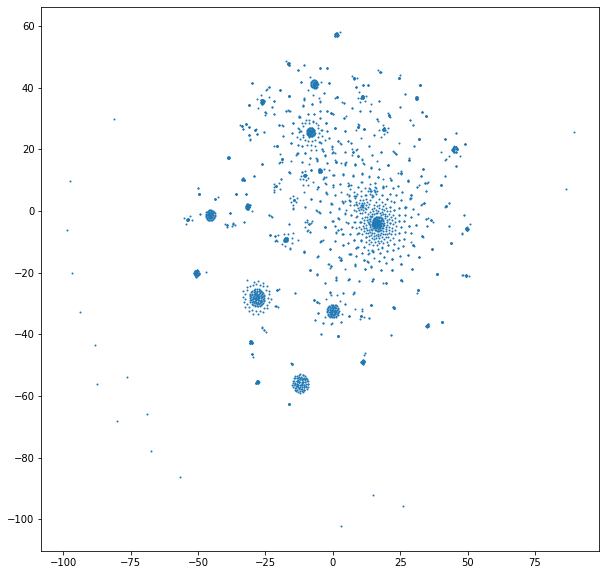

In [14]:
#using TSNE to reduce the dimensionality of the embeddings for just some words
print('Reducing dimensionality...')
tsne = TSNE(n_components=2)
embeddings_2d = tsne.fit_transform(embeddings[:2500])
print('Done!')

#plotting the embeddings using matplotlib
plt.figure(figsize=(10, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=1)
plt.show()

## TRAINING OWN EMBEDDING

In [31]:
import numpy as np
import pandas as pd
import os
import re
import time

from gensim.models import Word2Vec


In [32]:
sentences = []
start = 0
for i, word in enumerate(text_separated):
    if word in [".", '?', '!']:
        sentences.append(text_separated[start : i+1])
        start = i+1


In [37]:
sentences =  [item for item in sentences for _ in range(2)]

emb_model = Word2Vec(sentences=sentences,
                 min_count=1,
                 sg=1, 
                 vector_size =500,  
                 workers=4)


In [38]:
emb_model.wv.most_similar('food')

[('removes', 0.4833211302757263),
 ('furry', 0.43395447731018066),
 ('robs', 0.36258599162101746),
 ('wayside', 0.3469255566596985),
 ('fatherless', 0.34464189410209656),
 ('joint', 0.3368164598941803),
 ('snatch', 0.3361356556415558),
 ('imprudences', 0.33532077074050903),
 ('caballeros', 0.3314705789089203),
 ('whispering', 0.33011889457702637)]

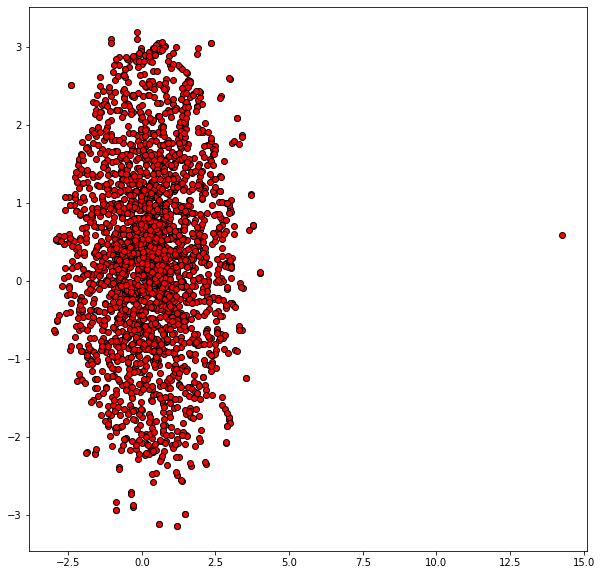

In [39]:
words = list(emb_model.wv.key_to_index)
vectors = emb_model.wv.vectors

# Step 2: Use t-SNE to reduce dimensionality
tsne = TSNE(n_components=2, random_state=0)
vectors_2d = tsne.fit_transform(vectors[:2500])

# Step 3: Plot the vectors
plt.figure(figsize=(10,10))
plt.scatter(vectors_2d[:,0], vectors_2d[:,1], edgecolors='k', c='r')
plt.show()

# MODEL: Making a Basic Bigram Model
Bigram models are the simplest form of language models that assigns probabilities to word sequences. It is based on the assumption that the probability of a word depends only on the previous word. In other words, it assumes that the probability of a word depends only on the previous word. The probability of a word depends on the previous two words in the case of a trigram model. The probability of a word depends on the previous n words in the case of an n-gram model.

This simple model is just a random model that generates the next character based on the last character (not even the last n-characters). *Tokens DO NOT talk to each other*.

In [19]:
class LayerNorm1d: # (used to be BatchNorm1d)
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    xmean = x.mean(1, keepdim=True) # batch mean
    xvar = x.var(1, keepdim=True) # batch variance
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]


In [20]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_random_batch(split, block_size = block_size, batch_size= batch_size)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear( n_embed, head_size, bias=False)
        self.query = nn.Linear( n_embed, head_size, bias=False)
        self.value = nn.Linear( n_embed, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embed,  n_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        proj = self.proj(out)
        out = self.dropout(proj)
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self,  n_embed):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear( n_embed, 4 *  n_embed),
            nn.ReLU(),
            nn.Linear(4 *  n_embed,  n_embed),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Transformer(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self,  n_embed, n_head):
        #  n_embed: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size =  n_embed // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward( n_embed)
        self.ln1 = nn.LayerNorm( n_embed)
        self.ln2 = nn.LayerNorm( n_embed)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x
    
class BigramModel(nn.Module):

    def __init__(self, char_vocab_size, n_embed):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(char_vocab_size,  n_embed)
        self.position_embedding_table = nn.Embedding(block_size,  n_embed)
        self.blocks = nn.Sequential(*[Transformer( n_embed, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm( n_embed) # final layer norm
        self.lm_head = nn.Linear( n_embed, char_vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,char_vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [21]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_random_batch(split, block_size = block_size, batch_size= batch_size)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear( n_embed, head_size, bias=False)
        self.query = nn.Linear( n_embed, head_size, bias=False)
        self.value = nn.Linear( n_embed, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embed,  n_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        proj = self.proj(out)
        out = self.dropout(proj)
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self,  n_embed):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear( n_embed, 4 *  n_embed),
            nn.ReLU(),
            nn.Linear(4 *  n_embed,  n_embed),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Transformer(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self,  n_embed, n_head):
        #  n_embed: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size =  n_embed // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward( n_embed)
        self.ln1 = nn.LayerNorm( n_embed)
        self.ln2 = nn.LayerNorm( n_embed)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x
    
class BigramModel(nn.Module):

    def __init__(self, char_vocab_size, n_embed):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(char_vocab_size,  n_embed)
        self.position_embedding_table = nn.Embedding(block_size,  n_embed)
        self.blocks = nn.Sequential(*[Transformer( n_embed, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm( n_embed) # final layer norm
        self.lm_head = nn.Linear( n_embed, char_vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,char_vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [22]:
# hyperparameters
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 256 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embed = 384
n_head = 6
n_layer = 6
dropout = 0.2
# n_embed // n_head must equal batch_size
model = BigramModel(token_voc_size, n_embed) word2vec_model, vocab_size, n_embed):
m = model.to(device)

print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')


optimizer = torch.optim.AdamW(m.parameters(), lr = 1e-3)

for step in range(max_iters):
    
    # every once in a while evaluate the loss on train and val sets
    if step % 200 == 0 or step == max_iters - 1:
        losses = estimate_loss()
        print(f"step {step}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        
    x_train, y_train = get_random_batch('train', block_size = block_size, batch_size= batch_size)
    #print(x_train)
    logits, loss = m(x_train, y_train)
    optimizer.zero_grad(set_to_none = 1)
    loss.backward()
    optimizer.step()
 

print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long).to(device), max_new_tokens=1000)[0].tolist()))

SyntaxError: invalid syntax (<ipython-input-22-27dfd9dffb00>, line 14)

In [ ]:
torch.save(m, 'model.pth')

## EMBEDDING WORD BY WORD TESTING

In [23]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_random_batch(split, block_size = block_size, batch_size= batch_size)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear( n_embed, head_size, bias=False)
        self.query = nn.Linear( n_embed, head_size, bias=False)
        self.value = nn.Linear( n_embed, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embed,  n_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        proj = self.proj(out)
        out = self.dropout(proj)
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self,  n_embed):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear( n_embed, 4 *  n_embed),
            nn.ReLU(),
            nn.Linear(4 *  n_embed,  n_embed),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Transformer(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self,  n_embed, n_head):
        #  n_embed: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size =  n_embed // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward( n_embed)
        self.ln1 = nn.LayerNorm( n_embed)
        self.ln2 = nn.LayerNorm( n_embed)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x
    
class BigramModel(nn.Module):

    def __init__(self, char_vocab_size, n_embed):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(char_vocab_size,  n_embed)
        self.position_embedding_table = nn.Embedding(block_size,  n_embed)
        self.blocks = nn.Sequential(*[Transformer( n_embed, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm( n_embed) # final layer norm
        self.lm_head = nn.Linear( n_embed, char_vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,char_vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [ ]:
epoch_list = []
train_loss = []
val_loss = []

In [26]:
# hyperparameters
data  = torch.tensor(encode(text), dtype=torch.long)
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 128 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 20
n_embed = 512
n_head = 32
n_layer = 32
dropout = 0.2
vocab_size = len(vocabulary)
# n_embed // n_head must equal batch_size

#defining model
import os.path
if os.path.exists('shared/project_models/gpt_from_scratch/model_backup.pth'):
    model = torch.load('shared/project_models/gpt_from_scratch/model_backup.pth')
else:
    model = BigramModel(vocab_size, n_embed)
m = model.to(device)
print('Model Defined')

# Setting the training split to 90%
train_split = int(0.9 * len(data))
train_data = data[:train_split]
val_data = data[train_split:]

print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')


optimizer = torch.optim.AdamW(m.parameters(), lr =learning_rate)

for step in range(max_iters):
    
    # every once in a while evaluate the loss on train and val sets
    if step % eval_interval == 0 or step == max_iters - 1:
        epoch_list.append(step)
        losses = estimate_loss()
        train_loss.append(losses['train'])
        val_loss.append(losses['val'])
        print(f"step {step}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        with open('model_training_loss.txt', 'a') as f:
            f.write(f"step {step}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}\n")
        torch.save(m, 'model_backup.pth')

        
    x_train, y_train = get_random_batch('train', block_size = block_size, batch_size= batch_size)
    #print(x_train)
    logits, loss = m(x_train, y_train)
    optimizer.zero_grad(set_to_none = 1)
    loss.backward()
    optimizer.step()

import matplotlib.pyplot as plt
plt.figure()
plt.plot(epoch_list, train_loss)
plt.plot(epoch_list, val_loss)
plt.show()

print(decode(m.generate(idx =torch.zeros((1, 1), dtype=torch.long).to(device), max_new_tokens=1000)[0].tolist()))

Model Defined
116.100596 M parameters
step 0: train loss 9.9113, val loss 9.9139
step 100: train loss 3.3677, val loss 3.5134
step 200: train loss 3.2999, val loss 3.4920
step 300: train loss 3.2765, val loss 3.4407
step 400: train loss 3.2584, val loss 3.4597
step 500: train loss 3.2337, val loss 3.4150
step 600: train loss 3.1771, val loss 3.3609
step 700: train loss 3.1171, val loss 3.3048
step 800: train loss 2.9977, val loss 3.1909


KeyboardInterrupt: 

In [ ]:
torch.save(m, 'model.pth')

In [ ]:
encoded = list(enc.encode('I am Testing this tokenization model.'))
print(encoded)
print([enc.decode([i]) for i in encoded])
print([emb_model[str] for str in [enc.decode([i]) for i in encoded]])

# get wmbeddings of these 
    

In [ ]:
model = Word2Vec(text) #traain using the direct translations from tokenized to list of strings!
model

#NEED TO MAKE EMBEDDINGS FOR EACH TOKENIZATION TRANSLATION (ORIGIN OF ERROR ABOVE)
# 1. separate original string text into sentences
# 2. for each sentence, run tokenization
# 3. for each tokenized sentence, do the same as in print([emb_model[str] for str in [enc.decode([i]) for i in encoded]]) above
# 4. With the list of sentences as [[], [], []], feed into Word2Vec(sentences)
# 5. Save model
# 6. Load as done before in the code and retest cell above

# https://machinelearningmastery.com/develop-word-embeddings-python-gensim/

#OPTION 2: FINETUNE MODEL DOWNLOADED